In [1]:
import numpy as np
import pandas as pd
import os
import sys
if sys.version_info[0] < 3: 
    import StringIO
else:
    from io import StringIO


In [2]:
import numpy as np
import pandas as pd
import os
import sys
if sys.version_info[0] < 3: 
    import StringIO
else:
    from io import StringIO


In [3]:
def getFilenames(dirname = "../data"):
    filenames = []
    for file in os.listdir(dirname):
        if file.endswith(".txt"):
            filenames.append(os.path.join(dirname,file))
    return filenames

filenames = getFilenames()


In [4]:
frames = []
labels = ['test_num', 'location', 'x', 'y', 'z', 't', 'weight']
test_num_offset = 0
for name in filenames:
    file = open(name,'r')
    data = file.readlines()
    data = data[3:]
    test = []
    lastnum = 0
    tests = []
    for datum in data:
        datum = datum.replace("[","")
        datum = datum.replace("]","")
        datum = datum.replace("\n","")
        datum = [float(field) for field in datum.split(", ")]
        testnum = datum[0]
        datum[0] = int(datum[0]) + test_num_offset

        if testnum != lastnum:
            tests.append(test)
            test = []
            lastnum = testnum
        test.append(tuple(datum))
    tests.append(test)
    for test in tests:
        frame = pd.DataFrame.from_records(test,columns=labels)
        frames.append(frame)
    test_num_offset = testnum

dataset = pd.concat(frames)
dataset.test_num = dataset.test_num.astype(int)

tests = np.unique(dataset['test_num'])
y = np.zeros(len(tests))
for num in tests:
    y[num] = dataset[dataset['test_num']==num]['location'].iloc[0]



In [5]:
np.save('../data/y.npy',y)
np.save('../data/dataset.npy',np.array(dataset))




In [6]:
import numpy as np
import pandas as pd
from tsfresh import extract_relevant_features
from tsfresh.feature_extraction import MinimalFCParameters
import matplotlib.pyplot as plt



In [7]:
data=np.load('../data/dataset.npy')
labels = ['test_num', 'location', 'x', 'y', 'z', 't', 'weight']
dataset = pd.DataFrame({ labels[0]:data[:,0].astype(int) , labels[1]:data[:,1] , labels[2]:data[:,2], \
labels[3]:data[:,3] , labels[4]:data[:,4] , labels[5]:data[:,5] , labels[6]:data[:,6]})
y = np.load('../data/y.npy')
y = pd.Series(y.astype(int))


In [8]:
def getTest(dataset,num):
    return dataset[dataset['test_num']==num]


In [9]:

features =  extract_relevant_features(dataset, y, column_id='test_num', column_sort='t', default_fc_parameters=MinimalFCParameters())
features.to_pickle('../data/features.pkl')

Feature Extraction: 100%|██████████| 20/20 [00:00<00:00, 29.65it/s]


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np


In [11]:
X = pd.read_pickle('../data/features.pkl')
y = np.load('../data/y.npy')
y = pd.Series(y.astype(int))
N = len(X)

rs = ShuffleSplit(n_splits=5, test_size=.25, random_state=8)
for tr,tst in rs.split(X):
    train_x = np.array(X)[tr]
    train_y = np.array(y)[tr]
    test_x = np.array(X)[tst]
    test_y = np.array(y)[tst]

In [12]:
def evalModel(model,train_x,train_y,test_x,test_y):
    y_hat = model.predict(test_x)
    print('Predicted classes: {0}'.format(np.unique(y_hat)))
    print('Training score: {0}'.format(model.score(train_x,train_y)))
    print('Test score: {0}'.format(model.score(test_x,test_y)))
    plt.matshow(confusion_matrix(test_y,y_hat))

In [13]:
forest = RandomForestClassifier(n_estimators=100)
forest.fit(train_x,train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Predicted classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Training score: 1.0
Test score: 0.584


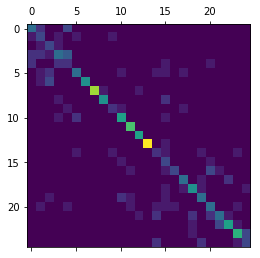

In [14]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(train_x,train_y)
evalModel(knn,train_x,train_y,test_x,test_y)


Predicted classes: [ 2  6  7  9 10 12 13 14 15 16 19 21 22 23]
Training score: 0.07610146862483311
Test score: 0.084


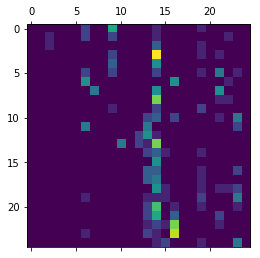

In [15]:
mlp = MLPClassifier(solver = 'adam', hidden_layer_sizes=(38,38),max_iter=int(1e4),random_state=8)
mlp.fit(train_x,train_y)
evalModel(mlp,train_x,train_y,test_x,test_y)
